In [84]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import pandas
import decimal
import copy

import db
from classes import State, Prices

from typing import Dict
import collections


In [85]:
"title: ZKLend Events Data"
connection = db.establish_connection()

# Load all Zklend events.
zklend_events = pandas.read_sql(
    sql = 
    f"""
    SELECT
        *
    FROM
        starkscan_events
    WHERE
        from_address='{constants.Protocol.ZKLEND.value}'
    AND
        key_name IN ('Deposit', 'Withdrawal', 'CollateralEnabled', 'CollateralDisabled', 'Borrowing', 'Repayment', 'Liquidation', 'AccumulatorsSync')
    ORDER BY
        block_number ASC, id;
    """,
    con = connection,
)

# Close the connection.
connection.close()

zklend_events.set_index('id', inplace = True)

/tmp/ipykernel_344809/891284722.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  zklend_events = pandas.read_sql(


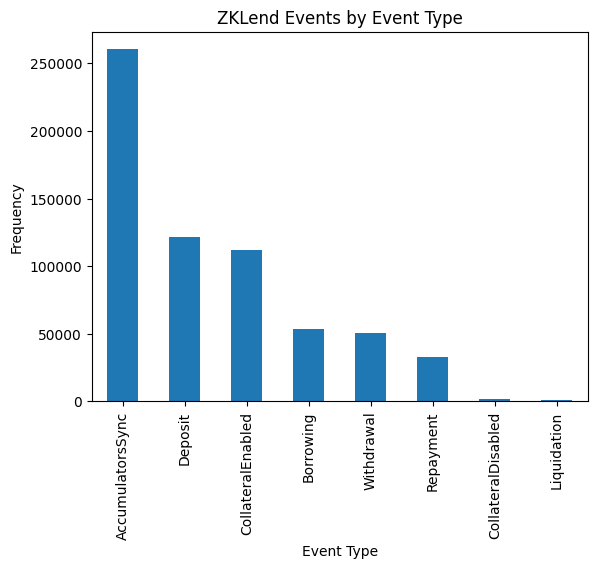

In [86]:
"title: ZKLend Events Visualization"
event_counts = zklend_events['key_name'].value_counts()
event_counts.plot(kind='bar');
plt.title("ZKLend Events by Event Type");
plt.xlabel("Event Type");
plt.ylabel("Frequency");


In [87]:
"title: Compute Max Liquidation Borrowings" 
def compute_borrowings_to_be_liquidated(
    risk_adjusted_collateral_usd: decimal.Decimal,
    borrowings_usd: decimal.Decimal,
    borrowings_token_price: decimal.Decimal,
    collateral_token_collateral_factor: decimal.Decimal,
    collateral_token_liquidation_bonus: decimal.Decimal,
) -> decimal.Decimal:
    # TODO: commit the derivation of the formula in a document?
    numerator = borrowings_usd - risk_adjusted_collateral_usd
    denominator = borrowings_token_price * (
        1 - collateral_token_collateral_factor * (
            1 + collateral_token_liquidation_bonus
        )
    )
    return numerator / denominator


def compute_max_liquidated_amount(
    state: classes.State,
    prices: Dict[str, decimal.Decimal],
    borrowings_token: str,
) -> decimal.Decimal:
    liquidated_borrowings_amount = decimal.Decimal('0')
    for user, user_state in state.user_states.items():
        # TODO: do this?
        # Filter out users who borrowed the token of interest.
        borrowings_tokens = {
            token_state.token
            for token_state in user_state.token_states.values()
            if token_state.borrowings > decimal.Decimal('0')
        }
        if not borrowings_token in borrowings_tokens:
            continue

        # Filter out users with health below 1.
        risk_adjusted_collateral_usd = compute_risk_adjusted_collateral_usd(
            user_state = user_state,
            prices = prices,
        )
        borrowings_usd = compute_borrowings_usd(
            user_state = user_state,
            prices = prices,
        )
        health_factor = compute_health_factor(
            risk_adjusted_collateral_usd = risk_adjusted_collateral_usd,
            borrowings_usd = borrowings_usd,
        )
        if health_factor >= decimal.Decimal('1'):
            continue

        # TODO: find out how much of the borrowings_token will be liquidated
        collateral_tokens = {
            token_state.token
            for token_state in user_state.token_states.values()
            if token_state.deposit * token_state.collateral_enabled > decimal.Decimal('0')
        }
        # TODO: choose the most optimal collateral_token to be liquidated .. or is the liquidator indifferent?
        collateral_token = list(collateral_tokens)[0]
        liquidated_borrowings_amount += compute_borrowings_to_be_liquidated(
            risk_adjusted_collateral_usd = risk_adjusted_collateral_usd,
            borrowings_usd = borrowings_usd,
            borrowings_token_price = prices[borrowings_token],
            collateral_token_collateral_factor = COLLATERAL_FACTORS[collateral_token],
            collateral_token_liquidation_bonus = LIQUIDATION_BONUSES[collateral_token],
        )
    return liquidated_borrowings_amount

In [88]:
#loan_size = compute_max_liquidated_amount(zklend_events, zklend_events[''])

In [89]:
# Histogram 
def plot_loan_hist(data): 
    plt.hist(data, bins = 5, x = "Loan Size", y = "Frequency")
    plt.title('Loan Size Visualization: Histogram');
    plt.show();